<a href="https://colab.research.google.com/github/Alitariq747/FoodVision101-PyTorch-Image-Classification-Problem/blob/main/PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Transfer Learning

What is transfer learning ?

Transfer Learning involves taking what one model has learned on another dataset and applying to our own problem.

 * Pretrained model = foundation models

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get data

We need our pizza, steak and sushki data to build a transfer learning model on.

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Set Up data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi' # images from a subset of classes from the food vision

# If the image folder doesn't exits, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} already exist, skipping download')
else:
  print(f'Did not find {image_path} downloading it...')
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the data from github
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(request.content)

  # Unzip the pizza, steak and sushi data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print(f'Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)

  # Delete .zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')

Did not find data/pizza_steak_sushi downloading it...
Unzipping pizza, steak and sushi data...


In [ ]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in Going Modular section..

There is one thing we need to think about when loading: how to **transform** it ?
And with `torhcvision` 0.13+ there's two ways we can do it:

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you would use in transfer learning.

Important point: when using a petrained model, its important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

In [ ]:
from going_modular.going_modular import data_setup



### 2.1 Creating a transform for torchvision.models (manual creation)
`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

You can use the following transform to normalize:

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

## normalize -> make sure that images have same distribution as ImageNet (where our pretrained models have ben trained .)

manual_transforms = transforms.Compose([transforms.Resize(size=(224,224)), # resize the image to size 224 x 224
                                        transforms.ToTensor(), # get images into range (0,1)
                                        normalize])

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7983731b7c40>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation) .

The key takeaway here is that if you want to use your data on pretrained models you could go over a data transfrom manually which can lead to errors or you can use the automatic transformation from model's pretrained weights available.

In [ ]:
# 1. Get the transforms used to create our pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'DEFAULT' -> best avaialble weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# 2. Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79837321a6b0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model such as:

1. Pytorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (many different models)
4. Paperswithcode (or models across different problem spaces / domains)


### 3.1 Which pretrained model you should pick ?

`experiment, experiment, experiment`

The whole idea of transfer learning is to pick up an already trained model on a problem similar to your own and then customize it your own problem.

Three things to consider:
1. Speed
2. Size
3. Performance

Depends also on where the model has to live.

On a mobile device or on a server ??

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# New method of creating a pretrained model(torchvision v0.13+)

# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

Some important things to note about transfer learning in general is that we keep the feature extraction and pooling layers as it is but change the output shape of classifier layer to suit our problem. Particularly our own number of classes.

Now what feature extraction layers does is that they learn the features from the data (we dont provide what features to learn) and output a giant tensor and pooling layers compress these feature tensors into a single giant vector which is then inputted into our classifier layer to outpt the prediction probabilities for our classes.

#### ORIGINAL MODEL VS FEATURE EXTRACTION TL Model:

Principle is the same: base layers remain frozen but input dataset and output classifier layers output_Shape alters as per our own dataset.

#### ANOTHER KIND OF TL: FINE TUNING

When we alter the parameters of the original model to suit our own problem and data. Its only suitable when we have large amounts of training data.

## 3.3 Model summary

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model, input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs.
With a feature extractor model, typically you will 'freeze' the base layers of a pretrained/foundation model and update the output/classifier layer to suit your own problem.

We freeze the base layers by turning their gradient tracking `off`..  

In [ ]:
# freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

The concept of dropout layer: It is a regularization technique to avoid overfitting by randomly removing some neurons from layers by a probability p.

In [ ]:
# Observe in summary again how our trainable parameters have gone down and
# only classifier linear layer has trainable / learnable patterns as we have to set them as per our needs
summary(model=model, input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names)).to(device) # how many classes we have
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model, input_size=(1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
# Import engine.py from going_modular section
from going_modular.going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the timer
from timeit import default_timer as timer
start_time = timer()

# Lets train our model using engine.py
results = engine.train(model=model, train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader, optimizer=optimizer,
                       loss_fn=loss_fn, epochs=5, device=device)

end_time = timer ()
print(f'Info: Total train time: {end_time - start_time} on cpu...')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
Info: Total train time: 169.6031924529998 on cpu...


## Evaluate model by plotting loss curve

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f'[INFO] Couldn"t find helper_functions.py, downloading...')
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py')
    f.write(request.content)



[INFO] Couldn"t find helper_functions.py, downloading...


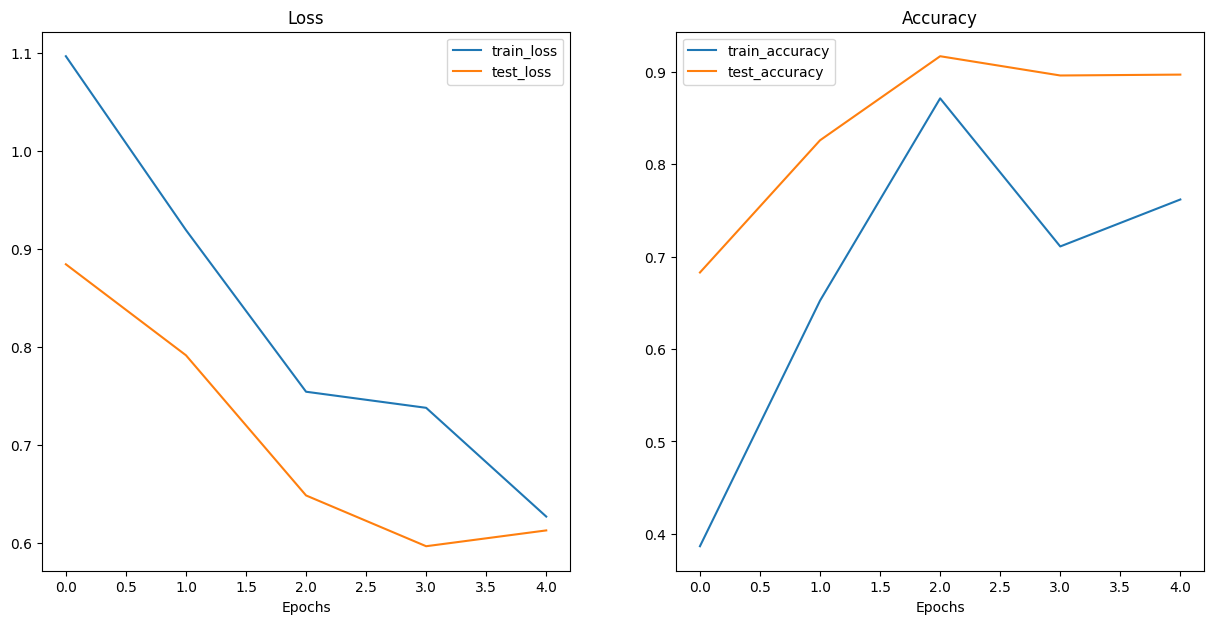

In [ ]:
  from helper_functions import plot_loss_curves
  plot_loss_curves(results)

## 6. Make predictions on images from the test set.

Some things to remember when making predictions / inference on custom data:

We have to make sure that our test/custom data is:
* Same shape
* Same datatype - custom data should be in the same data type
* Same device - custom data / test data should be on same device
* Same Transform

In [ ]:
# Creating a plot and predict image.
from typing import List, Tuple
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 1. Open the image with PIL
  img = Image.open(image_path)

  # 2. Create a transform if one doesn't exits
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])
  ### Predict on image ###
  # 4. Put model to device
  model.to(device)
  # Transform the image and add batch dimension
  transformed_image = image_transform(img).unsqueeze(0)
  # 5 Put the model in eval mode
  model.eval()
  with torch.inference_mode():
    target_image_pred = model(transformed_image.to(device))

  # Convert the target_image_pred LOGIT to pred_prob
  target_image_pred_prob = torch.softmax(target_image_pred, dim=1)

  # Convert the prediction probability to prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

  # Finally create a matplotlib plot and display the image
  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred: {class_names[target_image_pred_label]}, Prob: {target_image_pred_prob.max():.4f}')
  plt.axis(False);

In [ ]:
class_names

['pizza', 'steak', 'sushi']

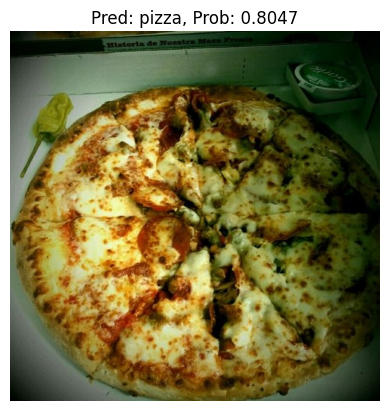

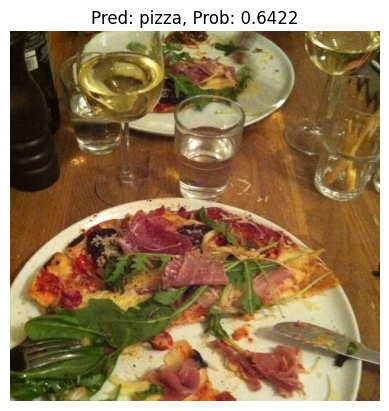

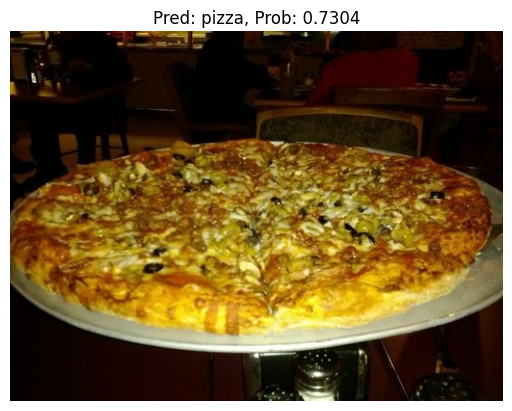

In [ ]:
# get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
for image in test_image_path_sample:
  pred_and_plot_image(model=model, image_path=image,
                      class_names=class_names
                      )

### 6.1 Make prediction on custom image

In [ ]:
data_path

PosixPath('data')

In [ ]:
# Download an image from github
import requests

# Check if image_path already exists
custom_image_path = data_path / '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # Download from github
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists, skipping download..')

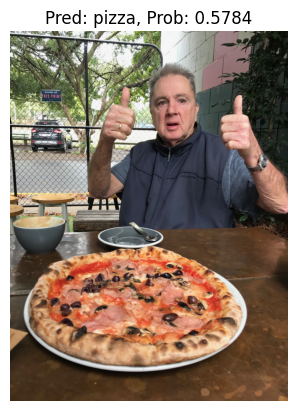

In [ ]:
# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)